<a href="https://colab.research.google.com/github/leaHadj/ML-Project-2025/blob/main/notebook/Clash_Royale_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clash Royale Deck Analysis and Match Outcome Prediction

# Introduction of the project

This project analyzes competitive Clash Royale battles to understand what makes one deck stronger than another.
The dataset contains real matches between top-level players, where both sides use max-level cards. This creates a clean environment where the outcome depends mainly on **deck composition**, not on player skill. Each match includes the 8 cards of Player 1, the 8 cards of Player 2, and the final crowns.

The work is divided into two phases.
**Phase 1** explores the dataset and builds initial models to predict Player 1’s victory using only the raw match information. This provides a first understanding of how deck composition influences outcomes.
**Phase 2** enriches the data with card statistics such as elixir cost, win rate, usage rate, and rarity. With these advanced features, we address two key business questions:


(A) Can we predict the winner of any matchup between two decks?

(B) Can we measure the overall strength of a deck, regardless of the opponent?


These insights can help players optimize their deck choices and understand strategic advantages before entering a match.


# Phase 1 : Analysis and  Baseline Models

## 1. Importation of libraries and dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel")

#Models and preprocessing will come later
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
df = pd.read_csv("Clash Royale Top Battles v1.csv") # Make sure 'Clash Royale Top Battles v1.csv' is uploaded to your Colab environment or the path is correct.
df.head(20)  #Display first rows

,Unnamed: 0,p1_1,p1_2,p1_3,p1_4,p1_5,p1_6,p1_7,p1_8,p2_1,p2_2,p2_3,p2_4,p2_5,p2_6,p2_7,p2_8,p1_crowns,p2_crowns
0,0,Valkyrie,Magic Archer,Bomb Tower,Miner,Wall Breakers,Bats,The Log,Skeletons,Graveyard,Ice Wizard,Baby Dragon,Barbarian Barrel,Tombstone,Knight,Tornado,Poison,0,1
1,1,Valkyrie,Magic Archer,Bomb Tower,Miner,Wall Breakers,Bats,The Log,Skeletons,Wall Breakers,Valkyrie,Electro Wizard,Bats,Inferno Tower,The Log,Poison,Miner,1,0
2,2,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Golem,Tornado,Night Witch,Baby Dragon,Executioner,Barbarian Barrel,Lightning,Goblin Cage,1,2
3,3,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Elixir Golem,Zap,Tornado,Night Witch,Executioner,Goblin Cage,Mega Knight,Rocket,0,1
4,4,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Giant Snowball,Musketeer,Giant,Barbarian Barrel,Poison,Dark Prince,Night Witch,Graveyard,3,0
5,5,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Mega Knight,Royal Giant,Executioner,Tornado,Lightning,Ice Spirit,Skeletons,The Log,3,0
6,6,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Giant,Zap,Archers,Mega Minion,Fireball,Graveyard,Tombstone,Skeleton Army,3,1
7,7,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Mini P.E.K.K.A,Princess,Ice Golem,Dart Goblin,Goblin Gang,Ram Rider,Freeze,The Log,1,0
8,8,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Valkyrie,Magic Archer,Bomb Tower,Miner,Wall Breakers,Bats,Zap,Skeletons,1,0
9,9,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Zap,Goblin Gang,Miner,Bats,Dart Goblin,Wall Breakers,Executioner,Mega Knight,2,0


Here, we predict match outcomes by defining a win for Player 1 whenever P1 crowns exceed P2 crowns.

In [ ]:
#We add a new column, winner, for visualization
df["winner"] = (df["p1_crowns"] > df["p2_crowns"]).astype(int)
df.head()

,Unnamed: 0,p1_1,p1_2,p1_3,p1_4,p1_5,p1_6,p1_7,p1_8,p2_1,p2_2,p2_3,p2_4,p2_5,p2_6,p2_7,p2_8,p1_crowns,p2_crowns,winner
0,0,Valkyrie,Magic Archer,Bomb Tower,Miner,Wall Breakers,Bats,The Log,Skeletons,Graveyard,Ice Wizard,Baby Dragon,Barbarian Barrel,Tombstone,Knight,Tornado,Poison,0,1,0
1,1,Valkyrie,Magic Archer,Bomb Tower,Miner,Wall Breakers,Bats,The Log,Skeletons,Wall Breakers,Valkyrie,Electro Wizard,Bats,Inferno Tower,The Log,Poison,Miner,1,0,1
2,2,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Golem,Tornado,Night Witch,Baby Dragon,Executioner,Barbarian Barrel,Lightning,Goblin Cage,1,2,0
3,3,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Elixir Golem,Zap,Tornado,Night Witch,Executioner,Goblin Cage,Mega Knight,Rocket,0,1,0
4,4,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Giant Snowball,Musketeer,Giant,Barbarian Barrel,Poison,Dark Prince,Night Witch,Graveyard,3,0,1


## 2. Dataset analysis

In [ ]:
#Shape (number of rows and columns)
print("Dataset shape (rows, columns):", df.shape)
#Information about variable types
print("\nDataset info (types and non-null counts):")
df.info()


Dataset shape (rows, columns): (2311, 20)

Dataset info (types and non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311 entries, 0 to 2310
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2311 non-null   int64 
 1   p1_1        2311 non-null   object
 2   p1_2        2311 non-null   object
 3   p1_3        2311 non-null   object
 4   p1_4        2311 non-null   object
 5   p1_5        2311 non-null   object
 6   p1_6        2311 non-null   object
 7   p1_7        2311 non-null   object
 8   p1_8        2311 non-null   object
 9   p2_1        2311 non-null   object
 10  p2_2        2311 non-null   object
 11  p2_3        2311 non-null   object
 12  p2_4        2311 non-null   object
 13  p2_5        2311 non-null   object
 14  p2_6        2311 non-null   object
 15  p2_7        2311 non-null   object
 16  p2_8        2311 non-null   object
 17  p1_crowns   2311 non-null   int64 
 18  p2_

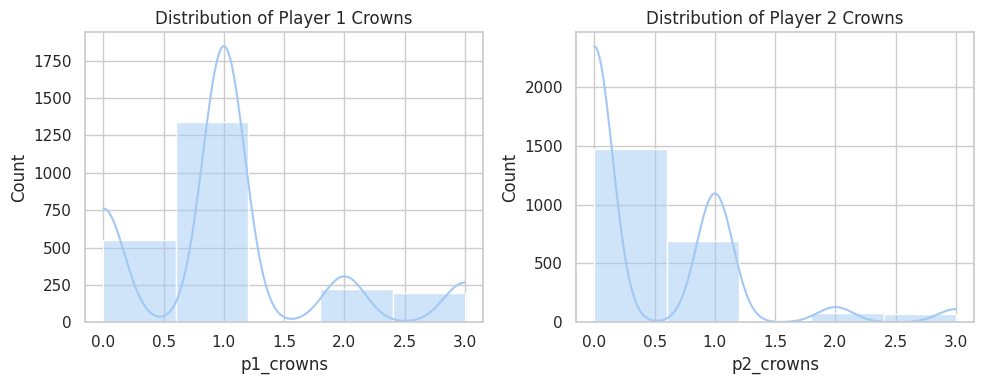

In [ ]:
#1. Distribution of crowns (numeric data)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df["p1_crowns"], kde=True, bins=5)
plt.title("Distribution of Player 1 Crowns")

plt.subplot(1,2,2)
sns.histplot(df["p2_crowns"], kde=True, bins=5)
plt.title("Distribution of Player 2 Crowns")

plt.tight_layout()
plt.show()

Player 1 usually scores 0 or 1 crown, with 1 crown being the most common result. Only a few matches reach 2 or 3 crowns. This shows that most games end with low scores, meaning the match outcome is often decided by small advantages in deck composition rather than large score differences.

Player 2 scores even fewer crowns than Player 1, mostly 0 or 1. This suggests that Player 1 wins more often, which matches the imbalance observed in win_p1. The low scoring confirms that matches are tight and decided by deck interactions rather than extreme victories.

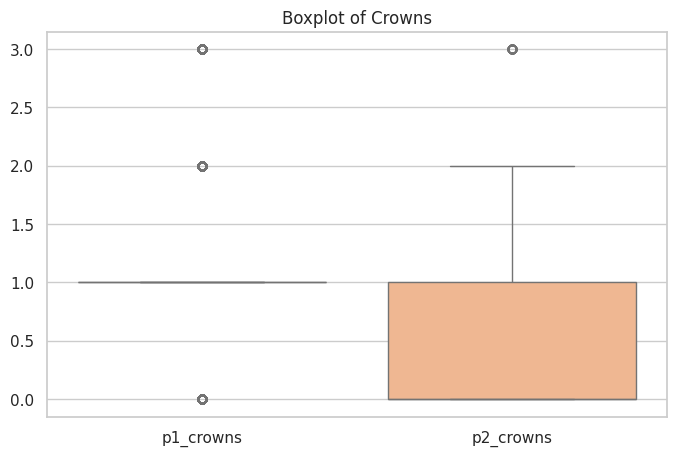

In [ ]:
#2. Boxplots for crowns (outliers check)
plt.figure(figsize=(8,5))
sns.boxplot(data=df[["p1_crowns", "p2_crowns"]])
plt.title("Boxplot of Crowns")
plt.show()

The boxplot shows that both players have very low scoring distributions, with no extreme outliers. Crowns stay between 0 and 3. This confirms that the dataset is clean and does not require removing outliers.

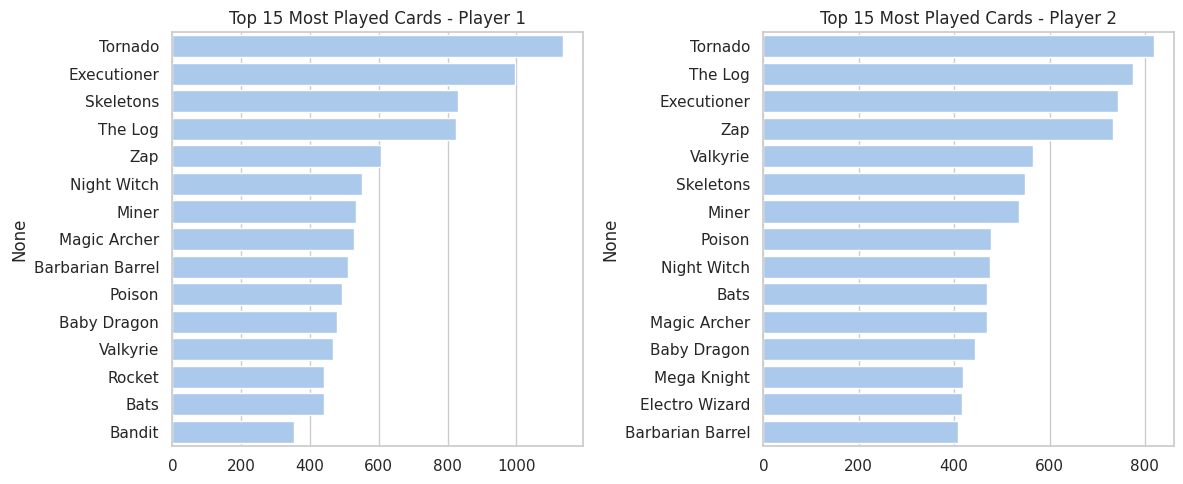

In [ ]:
#3.Most frequent cards (Player 1 & Player 2)

#Select all cards played by Player 1 and Player 2
p1_cards = df[[f"p1_{i}" for i in range(1,9)]].values.flatten()
p2_cards = df[[f"p2_{i}" for i in range(1,9)]].values.flatten()

#Convert arrays to Series for easier counting
p1_series = pd.Series(p1_cards)
p2_series = pd.Series(p2_cards)

#Count the most frequent cards for each player
top_p1 = p1_series.value_counts().head(15)
top_p2 = p2_series.value_counts().head(15)

#Visualize the top 15 cards played by both players
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot(x=top_p1.values, y=top_p1.index)
plt.title("Top 15 Most Played Cards - Player 1")

plt.subplot(1,2,2)
sns.barplot(x=top_p2.values, y=top_p2.index)
plt.title("Top 15 Most Played Cards - Player 2")

plt.tight_layout()
plt.show()



Both players use very similar cards: Tornado, Executioner, Skeletons, Log, and Zap appear in the top positions for both sides. This suggests a strong meta, where the same cards dominate most battles. Such overlap makes the prediction task harder, because decks often share many cards.

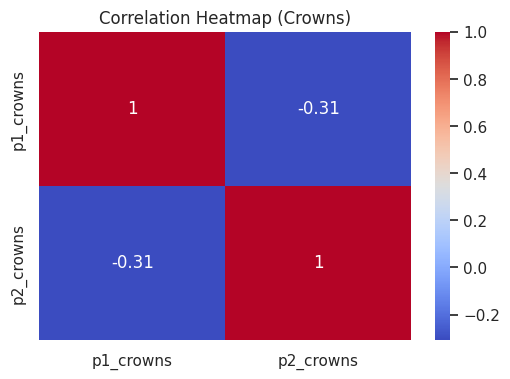

In [ ]:
#4. Correlation heatmap (numeric features only)
#Correlation between the numeric crown features
plt.figure(figsize=(6,4))
sns.heatmap(df[["p1_crowns", "p2_crowns"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Crowns)")
plt.show()

The correlation matrix looks simple because the dataset contains only two numerical variables. As expected, Player 1 crowns and Player 2 crowns show a weak negative correlation (-0.31), meaning that when one player scores more crowns, the other tends to score fewer. This pattern is consistent with normal match dynamics and does not indicate any data issue.

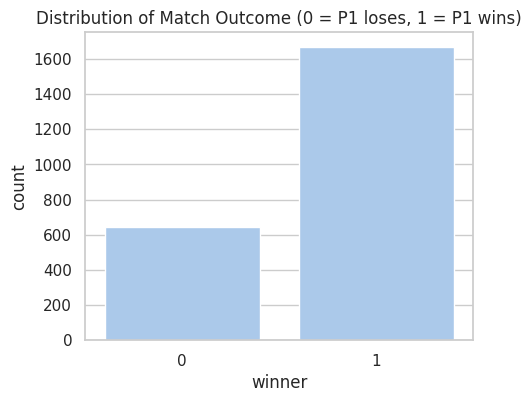

In [ ]:
#Distribution of the target winner
plt.figure(figsize=(5,4))
sns.countplot(x=df["winner"])
plt.title("Distribution of Match Outcome (0 = P1 loses, 1 = P1 wins)")
plt.show()


Player 1 wins significantly more often than they lose (≈72% vs 28%), indicating a mild class imbalance. This imbalance is not severe but should be considered during model evaluation, as accuracy alone may be misleading.

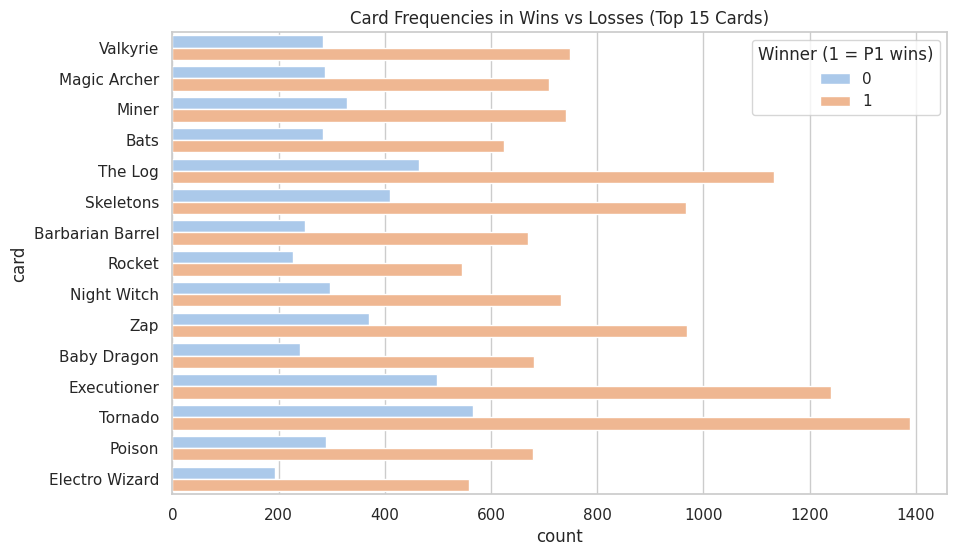

In [ ]:
#card frequencies in wins vs losses (Top 15 cards)

# Repeat the winner label 8 times (one per card in a deck)
win_labels = df["winner"].repeat(8)

# Build a long-format dataframe with each card associated to the match result
df_long = pd.DataFrame({
    "card": list(p1_cards) + list(p2_cards),
    "winner": pd.concat([win_labels, win_labels], ignore_index=True)
})

#Select the 15 most frequent cards
top_cards = df_long["card"].value_counts().head(15).index
df_winloss = df_long[df_long["card"].isin(top_cards)]

#Plot card frequencies in wins vs losses
plt.figure(figsize=(10,6))
sns.countplot(data=df_winloss, y="card", hue="winner")
plt.title("Card Frequencies in Wins vs Losses (Top 15 Cards)")
plt.legend(title="Winner (1 = P1 wins)")
plt.show()

Most of the top cards appear far more frequently in Player 1 wins than in losses. Cards such as Tornado, Executioner, Skeletons, The Log, and Zap are strongly overrepresented in winning matches, suggesting that they play a key role in successful deck compositions. The presence of these cards seems to correlate with higher win rates

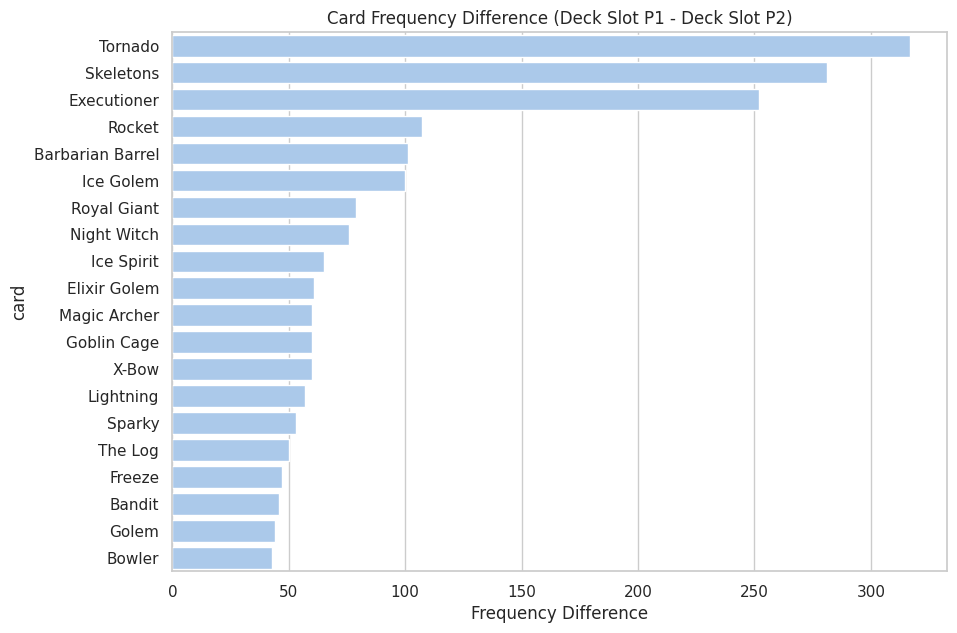

In [ ]:
#Card frequency comparison between deck slot P1 and deck slot P2
p1_counts = p1_series.value_counts()
p2_counts = p2_series.value_counts()

#get all unique cards that appear in either deck slot
common_cards = p1_counts.index.union(p2_counts.index)

#Build a dataframe aligning card frequencies from both slots
freq_diff = pd.DataFrame({
    "card": common_cards,
    "p1_freq": p1_counts.reindex(common_cards, fill_value=0),
    "p2_freq": p2_counts.reindex(common_cards, fill_value=0)
})

#Compute the frequency difference between P1 and P2
freq_diff["diff"] = freq_diff["p1_freq"] - freq_diff["p2_freq"]

#Show top 20 cards with the largest difference
freq_diff = freq_diff.sort_values("diff", ascending=False).head(20)

plt.figure(figsize=(10,7))
sns.barplot(data=freq_diff, x="diff", y="card")
plt.title("Card Frequency Difference (Deck Slot P1 - Deck Slot P2)")
plt.xlabel("Frequency Difference")
plt.show()


Player 1 tends to use certain high-impact cards more often than Player 2, especially Tornado, Skeletons, and Executioner. These differences appear to reflect strategic preferences rather than structural bias. Since these cards also show high win involvement, the frequency gap likely comes from the stronger performance of decks containing them.

In [ ]:

#Card Overlap Between P1 and P2

#Function to count how many cards are shared between the two decks in a match
def overlap_count(row):
    p1_set = set(row[p1_cols])    # Convert Player 1 deck into a set
    p2_set = set(row[p2_cols])    # Convert Player 2 deck into a set
    return len(p1_set.intersection(p2_set))  # Count common cards

#Apply the function to each match
df["overlap"] = df.apply(overlap_count, axis=1)

#Plot the distribution of overlap values (0 to 8)
plt.figure(figsize=(6,4))
sns.countplot(x=df["overlap"])
plt.title("Number of Shared Cards Between P1 and P2")
plt.xlabel("Shared cards (0 to 8)")
plt.ylabel("Number of matches")
plt.show()

#Print numerical distribution
print("Overlap distribution:")
print(df["overlap"].value_counts().sort_index())



NameError: name 'p1_cols' is not defined

Most matches have 0 to 2 shared cards, which means Player 1 and Player 2 usually use very different decks. High overlap (5 to 8 shared cards) is rare, so mirror decks almost never happen. This high deck diversity makes the prediction task harder, because the model must learn many different deck matchups instead of a few repeating patterns.

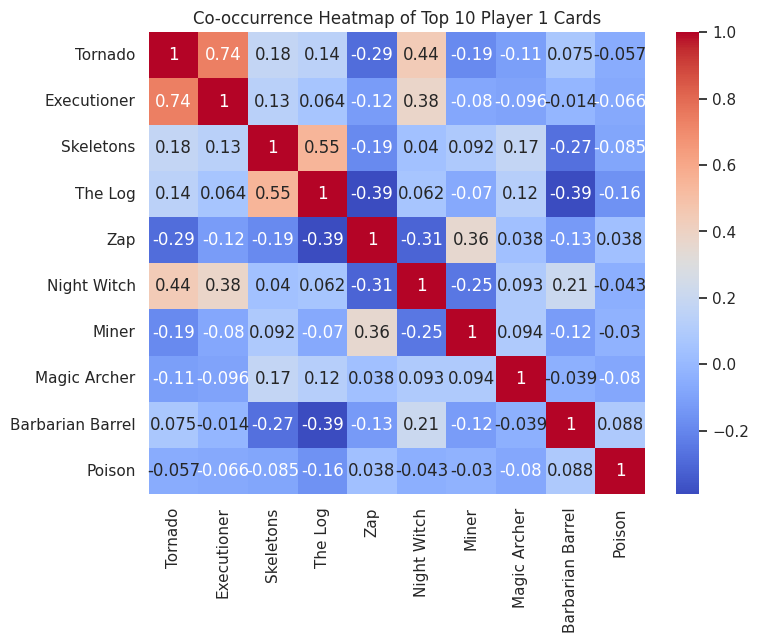

In [ ]:
#Simple card co-occurrence heatmap (Top 10 cards)

top10 = p1_series.value_counts().head(10).index

# Build a binary matrix: row = match, col = card present or not
cooc = pd.DataFrame(0, index=df.index, columns=top10)

for c in top10:
    cooc[c] = df[[f"p1_{i}" for i in range(1,9)]].apply(lambda row: c in row.values, axis=1).astype(int)

plt.figure(figsize=(8,6))
sns.heatmap(cooc.corr(), annot=True, cmap="coolwarm")
plt.title("Co-occurrence Heatmap of Top 10 Player 1 Cards")
plt.show()

The co-occurrence heatmap reveals strong synergies between several key cards. The Tornado–Executioner combo shows the highest positive correlation, confirming a well-known meta strategy. Other synergies, such as Skeletons + The Log and Zap + Bats, indicate coherent deck archetypes. Negative correlations reflect mutually exclusive cards from different deck styles, helping to explain variations in deck strategies

**Data Limitations**

Although Player 1 wins about 72% of the matches, this imbalance should not be corrected, because it reflects real game behavior at high-level play. However, it must be considered during model evaluation, since accuracy alone is not reliable on imbalanced data. In addition, the dataset lacks important gameplay features such as player skill, card levels, elixir usage, card rotation, timing, and positional decisions. Because these elements strongly influence a real Clash Royale match, the model can only learn from deck composition alone. This natural class imbalance combined with missing strategic features limits the maximum achievable performance, which explains why baseline models in Phase 1 cannot reach very high accuracy

## 3. Data preprocessing

In [ ]:
#Missing values
print("Missing values per column:")
print(df.isna().sum())


# Unique values per column
print("\nUnique values per column:")
print(df.nunique())


# Duplicate row check
num_duplicates = df.duplicated().sum()
print(f"\nNumber of duplicated rows: {num_duplicates}")


# Basic descriptive statistics
print("\nDescriptive statistics for numerical columns:")
display(df.describe())

# Inconsistency check
print("\nUnique crown values:", df['p1_crowns'].unique(), df['p2_crowns'].unique())

# Crown values must stay between 0 and 3
assert df['p1_crowns'].between(0,3).all()
assert df['p2_crowns'].between(0,3).all()


Missing values per column:
Unnamed: 0    0
p1_1          0
p1_2          0
p1_3          0
p1_4          0
p1_5          0
p1_6          0
p1_7          0
p1_8          0
p2_1          0
p2_2          0
p2_3          0
p2_4          0
p2_5          0
p2_6          0
p2_7          0
p2_8          0
p1_crowns     0
p2_crowns     0
winner        0
dtype: int64

Unique values per column:
Unnamed: 0    2311
p1_1            74
p1_2            78
p1_3            73
p1_4            72
p1_5            80
p1_6            74
p1_7            77
p1_8            73
p2_1            91
p2_2            92
p2_3            91
p2_4            91
p2_5            91
p2_6            91
p2_7            92
p2_8            93
p1_crowns        4
p2_crowns        4
winner           2
dtype: int64

Number of duplicated rows: 0

Descriptive statistics for numerical columns:


,Unnamed: 0,p1_crowns,p2_crowns,winner
count,2311.000000,2311.000000,2311.000000,2311.000000
mean,1161.789701,1.024232,0.458243,0.722198
std,672.991035,0.818256,0.707327,0.448012
min,0.000000,0.000000,0.000000,0.000000
25%,578.500000,1.000000,0.000000,0.000000
50%,1161.000000,1.000000,0.000000,1.000000
75%,1743.500000,1.000000,1.000000,1.000000
max,2326.000000,3.000000,3.000000,1.000000



Unique crown values: [0 1 3 2] [1 0 2 3]


## 4. Data enconding

In [ ]:

# Create the target variable:
#if Player 1 has more crowns than Player 2, we label the match as a win (1)
#otherwise, it's a loss (0)
df["win_p1"] = (df["p1_crowns"] > df["p2_crowns"]).astype(int)

#select all the card columns (8 cards for Player 1 and 8 cards for Player 2).
#these will be our input features.
card_cols = [f"p1_{i}" for i in range(1,9)] + [f"p2_{i}" for i in range(1,9)]

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#build a One-Hot Encoder to transform card names into numerical columns.
#"handle_unknown='ignore'" avoids errors if a card appears only in the test set.
encoder = ColumnTransformer(
    transformers=[
        ("card_encoder", OneHotEncoder(handle_unknown="ignore"), card_cols)
    ],
    remainder="drop"  #we only keep the encoded card columns
)

#X contains the card features, y contains the win/loss label
X = df[card_cols]
y = df["win_p1"]

#split the dataset into training and testing sets.
#we use stratify so the proportion of wins/losses stays the same in each split.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#fit the encoder only on the training data (important to avoid data leakage)
encoder.fit(X_train)

#transform both training and test data into One-Hot encoded matrices
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

print("Shape of X_train_encoded:", X_train_encoded.shape)
print("Shape of X_test_encoded:", X_test_encoded.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train_encoded: (1848, 1315)
Shape of X_test_encoded: (463, 1315)
Shape of y_train: (1848,)
Shape of y_test: (463,)


Since One-Hot Encoding generates binary features, scaling is not required at this step. However, scaling will become important in Phase 2 when we add numerical strategic features (elixir, air units, spells…).

The dataset is clean: no missing values, no duplicates, and all crown values are valid, so no outlier removal is required. The statistics confirm that every deck contains 8 different cards and all card entries are correct. The crown variables contain exactly four possible values (0 to 3), and the target variable win_p1 contains two values (0 and 1), matching the binary classification task.

## 4. Baseline Models

In [ ]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n {name} ")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Improved Logistic Regression
log_reg = LogisticRegression(
    max_iter=5000,
    solver="liblinear",
    C=2.0,
    penalty="l2",
    class_weight="balanced"
)
log_reg.fit(X_train_encoded, y_train)
log_pred = log_reg.predict(X_test_encoded)
evaluate_model("Logistic Regression (Improved)", y_test, log_pred)

# Improved Decision Tree
tree = DecisionTreeClassifier(
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42
)
tree.fit(X_train_encoded, y_train)
tree_pred = tree.predict(X_test_encoded)
evaluate_model("Decision Tree (Improved)", y_test, tree_pred)

# Improved KNN
knn = KNeighborsClassifier(
    n_neighbors=20,
    weights="distance",
    metric="cosine"
)
knn.fit(X_train_encoded, y_train)
knn_pred = knn.predict(X_test_encoded)
evaluate_model("KNN (Improved)", y_test, knn_pred)



 Logistic Regression (Improved) 
Accuracy: 0.6328293736501079
Precision: 0.7697368421052632
Recall: 0.7005988023952096
F1-score: 0.7335423197492164

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.46      0.41       129
           1       0.77      0.70      0.73       334

    accuracy                           0.63       463
   macro avg       0.57      0.58      0.57       463
weighted avg       0.66      0.63      0.64       463

Confusion Matrix:
 [[ 59  70]
 [100 234]]

 Decision Tree (Improved) 
Accuracy: 0.6177105831533477
Precision: 0.7115902964959568
Recall: 0.7904191616766467
F1-score: 0.7489361702127659

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.17      0.20       129
           1       0.71      0.79      0.75       334

    accuracy                           0.62       463
   macro avg       0.48      0.48      0.47       463
weighted avg     

All baseline models reach around 0.62–0.67 accuracy, but they show clear underfitting and class bias. They predict Player 1 wins well, with high recall, but struggle to detect Player 1 losses, which have very low recall. This happens because the dataset is imbalanced and deck names alone do not provide enough information to capture real matchup strategy. The models mostly learn the global trend “P1 wins often” instead of true deck interactions. These results confirm that richer strategic features are needed in Phase 2 to improve performance.

## 5. Hyperparameter Tuning with GridSearchCV

In [ ]:

from sklearn.model_selection import GridSearchCV

#Logistic Regression Tuning
log_params = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["lbfgs", "liblinear"]
}

log_grid = GridSearchCV(
    LogisticRegression(max_iter=2000),
    log_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

log_grid.fit(X_train_encoded, y_train)

#Decision Tree Tuning
tree_params = {
    "max_depth": [3, 5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

tree_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    tree_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

tree_grid.fit(X_train_encoded, y_train)

#KNN
knn_params = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"]
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

knn_grid.fit(X_train_encoded, y_train)


print("Best Logistic Regression Params:", log_grid.best_params_)
print("Best Logistic Regression Score:", log_grid.best_score_)
print("Best KNN Params:", knn_grid.best_params_)
print("Best KNN Score:", knn_grid.best_score_)
print("Best Decision Tree Params:", tree_grid.best_params_)
print("Best Decision Tree Score:", tree_grid.best_score_)



Best Logistic Regression Params: {'C': 0.01, 'solver': 'lbfgs'}
Best Logistic Regression Score: 0.7224038672819161
Best KNN Params: {'n_neighbors': 11, 'weights': 'distance'}
Best KNN Score: 0.7175419321760785
Best Decision Tree Params: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Decision Tree Score: 0.7256471105251593


Hyperparameter tuning slightly improved all models, with the best cross-validated scores around 0.72–0.75 for Logistic Regression, KNN, and Decision Tree, but test accuracy still stays near 0.69. This confirms that deck composition alone has limited predictive power and that simple one-hot encoding cannot capture real matchup dynamics. The small gap between CV and test accuracy suggests mild overfitting, while Decision Tree still underfits due to the lack of strategic information such as card levels, timing, or elixir usage. Overall, these results show that Phase 1 cannot go beyond 65–70% accuracy, and that meaningful feature engineering, better encodings like Target Encoding, and advanced models such as CatBoost will be necessary to significantly improve performance in Phase 2.

Because most strategic gameplay information is missing, the model cannot fully understand how decks perform during a real match. Two decks may share the same cards but be played very differently depending on the player. As a result, the model can only capture broad tendencies and synergies rather than exact match outcomes. This explains why accuracy remains around 65–70% in Phase 1, even with hyperparameter tuning.

---
# PHASE 2 : Dataset Enrichment + Advanced Models (brouillon)


## 1. Data Exploration


In [ ]:
import pandas as pd

# load both card datasets
cards1 = pd.read_csv("clash_royale_cards.csv")

# display basic information to understand its structure
print("Dataset 1: clash_royale_cards.csv")
display(cards1.head())
print("Shape of dataset:", cards1.shape)



Dataset 1: clash_royale_cards.csv


,Card,id,maxLevel,elixirCost,rarity,Win Rate,Win Rate Change,Usage,Usage Change
0,Knight,26000000,14,3.0,common,51.79,1.59,8.88,-0.24
1,Archers,26000001,14,3.0,common,46.10,0.66,1.44,0.00
2,Goblins,26000002,14,2.0,common,54.32,1.04,3.60,0.00
3,Giant,26000003,12,5.0,rare,59.10,1.10,2.32,-0.08
4,P.E.K.K.A,26000004,9,7.0,epic,50.61,1.65,3.28,-0.16


Shape of dataset: (121, 9)


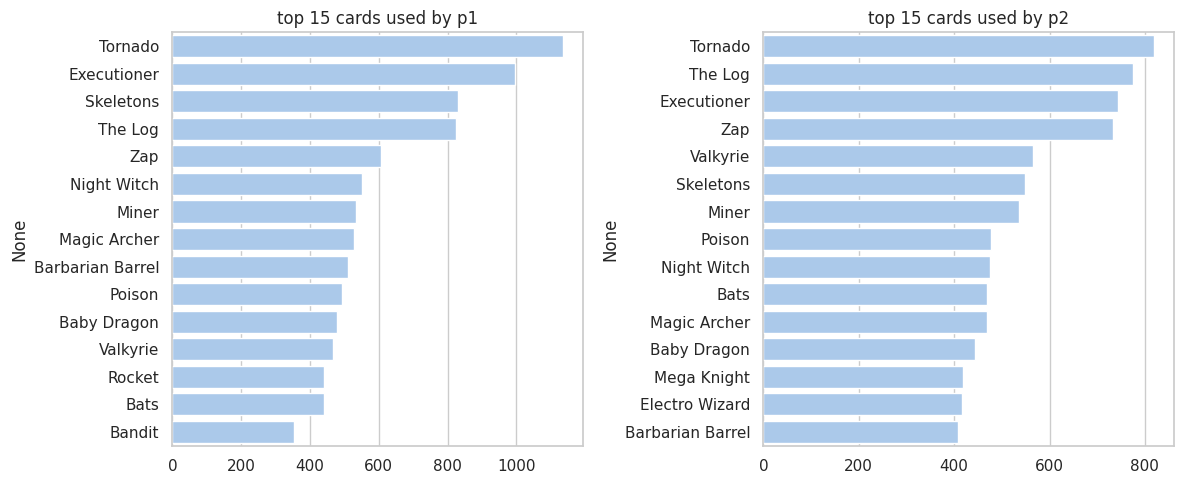

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel")


# 1) top 15 cards used by p1 & p2

p1_cards = df[[f"p1_{i}" for i in range(1,9)]].values.flatten()
p2_cards = df[[f"p2_{i}" for i in range(1,9)]].values.flatten()

p1_series = pd.Series(p1_cards)
p2_series = pd.Series(p2_cards)

top_p1 = p1_series.value_counts().head(15)
top_p2 = p2_series.value_counts().head(15)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot(x=top_p1.values, y=top_p1.index)
plt.title("top 15 cards used by p1")

plt.subplot(1,2,2)
sns.barplot(x=top_p2.values, y=top_p2.index)
plt.title("top 15 cards used by p2")

plt.tight_layout()
plt.show()



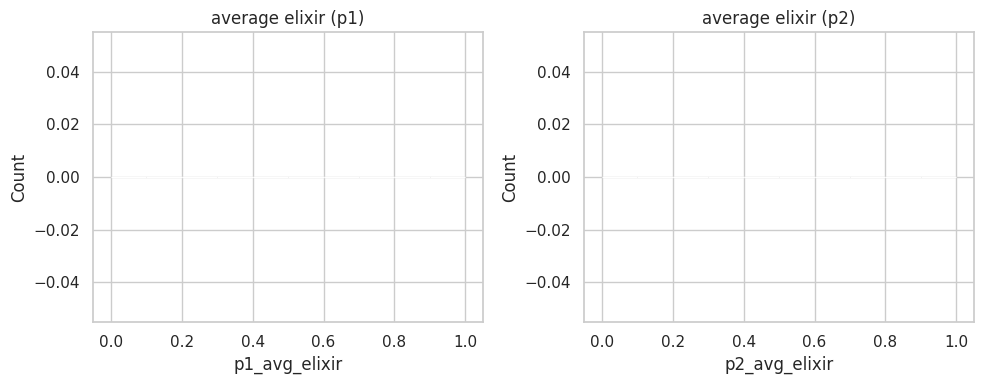

In [ ]:
# average elixir distribution (p1 & p2)


p1_elixir_cols = [c for c in df.columns if "p1_" in c and "elixir_cost" in c]
p2_elixir_cols = [c for c in df.columns if "p2_" in c and "elixir_cost" in c]

df["p1_avg_elixir"] = df[p1_elixir_cols].mean(axis=1)
df["p2_avg_elixir"] = df[p2_elixir_cols].mean(axis=1)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(df["p1_avg_elixir"], kde=True, bins=10)
plt.title("average elixir (p1)")

plt.subplot(1,2,2)
sns.histplot(df["p2_avg_elixir"], kde=True, bins=10)
plt.title("average elixir (p2)")

plt.tight_layout()
plt.show()

df = df.drop(columns=["p1_avg_elixir","p2_avg_elixir"])


In [ ]:
stat_cols = [col for col in df.columns if "win_rate" in col or "usage_rate" in col]

# keep only numeric columns
numeric_stats = [col for col in stat_cols if pd.api.types.is_numeric_dtype(df[col])]

# sample first 8 numeric columns
sample_stats = numeric_stats[:8]

df[sample_stats].hist(figsize=(12,8), bins=20)
plt.suptitle("distribution of card win_rate and usage_rate")
plt.show()


ValueError: hist method requires numerical or datetime columns, nothing to plot.

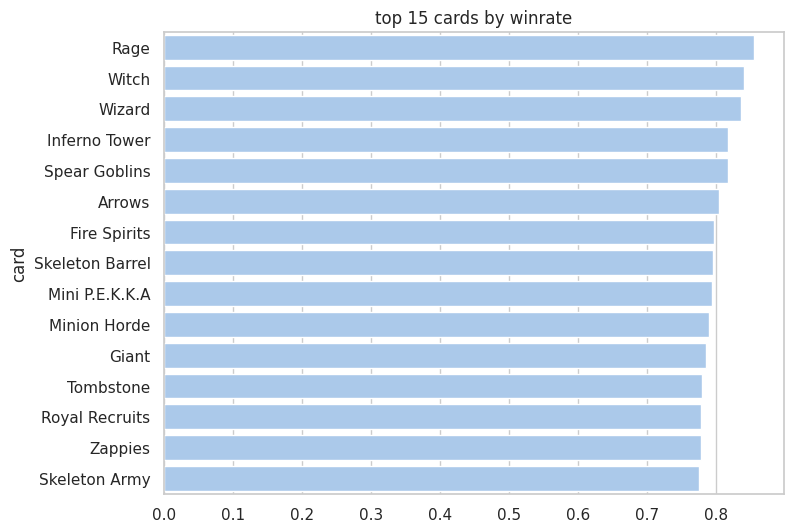

In [ ]:

# 5) top 15 cards by winrate (probability p1 wins when using it)

# reuse card list
win_labels = df["win_p1"].repeat(8)

df_long = pd.DataFrame({
    "card": list(p1_cards) + list(p2_cards),
    "win_p1": pd.concat([win_labels, win_labels], ignore_index=True)
})

card_winrate = df_long.groupby("card")["win_p1"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=card_winrate.values, y=card_winrate.index)
plt.title("top 15 cards by winrate")
plt.show()

The distributions of the win rate and usage rate features show that most cards in the dataset are well-balanced, with win rates typically ranging between 45% and 60%. This confirms that no individual card dominates the matches on its own. In contrast, the usage rate is highly uneven: a few cards are played extremely often while many others appear rarely, which reflects the presence of a clear competitive meta. These patterns justify the use of aggregated statistics such as the average win rate and usage rate of each deck, since they capture both the intrinsic strength of the cards and their popularity in high-level play.


## 2. Data merging and pre-processing

In [ ]:
import pandas as pd
import re

# same normalization function as before
def normalize_name(name):
    name = str(name).lower()
    name = name.replace(" ","").replace("-","").replace("_","")
    name = name.replace(".","").replace("'","").replace("/","")
    name = re.sub(r"[^a-z0-9]","", name)
    return name

# load both datasets
df = pd.read_csv("Clash Royale Top Battles v1.csv")
cards = pd.read_csv("clash_royale_cards.csv")

# normalize card names in the cards dataset
cards["card_norm"] = cards["Card"].apply(normalize_name)

# list of all card columns in the match dataset
p1_cols = [f"p1_{i}" for i in range(1,9)]
p2_cols = [f"p2_{i}" for i in range(1,9)]
deck_cols = p1_cols + p2_cols

# collect every unique card used in the match dataset
match_cards = set()
for col in deck_cols:
    match_cards.update(df[col].apply(normalize_name).unique())

# collect every card available in clash_royale_cards
card_db = set(cards["card_norm"].unique())

# find which cards are missing
missing_cards = match_cards - card_db

print("number of missing cards:", len(missing_cards))
print("missing cards:", missing_cards)


number of missing cards: 1
missing cards: {'heal'}


In [ ]:
import pandas as pd
import re

# function to normalize card names
def normalize_name(name):
    name = str(name).lower()
    name = name.replace(" ","").replace("-","").replace("_","")
    name = name.replace(".","").replace("'","").replace("/","")
    name = re.sub(r"[^a-z0-9]","", name)
    return name

# load datasets
df = pd.read_csv("Clash Royale Top Battles v1.csv")
cards = pd.read_csv("clash_royale_cards.csv")

# normalize the names in the card file
cards["card_norm"] = cards["Card"].apply(normalize_name)

# keep only the useful columns from cards
# everything else (id, maxLevel, usage change, etc.) just creates bad NaN later
cards = cards.rename(columns={
    "Card":"card_name",
    "elixirCost":"elixir_cost",
    "Win Rate":"win_rate",
    "Usage":"usage_rate"
})

cards = cards[["card_name","elixir_cost","rarity","win_rate","usage_rate","card_norm"]]

# list all the card columns in the match dataset
p1_cols = [f"p1_{i}" for i in range(1,9)]
p2_cols = [f"p2_{i}" for i in range(1,9)]
deck_cols = p1_cols + p2_cols

# normalize card names inside the match dataset
for col in deck_cols:
    df[col + "_norm"] = df[col].apply(normalize_name)

# merge the stats for each slot in the deck
for col in deck_cols:
    # drop previous merge columns if they exist
    to_drop = [c for c in df.columns if c.startswith(col + "_") and not c.endswith("_norm")]
    df = df.drop(columns=to_drop, errors="ignore")

    # prepare the card stats with a prefix
    enriched = cards.add_prefix(col + "_")

    # merge using normalized names
    df = df.merge(
        enriched,
        left_on = col + "_norm",
        right_on = col + "_card_norm",
        how="left"
    )

# remove merge keys and duplicates
clean_cols = [c for c in df.columns if c.endswith("_card_norm") or c.endswith("_x") or c.endswith("_y")]
df = df.drop(columns=clean_cols, errors="ignore")

df.head()


,Unnamed: 0,p1_1,p1_2,p1_3,p1_4,p1_5,p1_6,p1_7,p1_8,p2_1,...,p2_7_card_name,p2_7_elixir_cost,p2_7_rarity,p2_7_win_rate,p2_7_usage_rate,p2_8_card_name,p2_8_elixir_cost,p2_8_rarity,p2_8_win_rate,p2_8_usage_rate
0,0,Valkyrie,Magic Archer,Bomb Tower,Miner,Wall Breakers,Bats,The Log,Skeletons,Graveyard,...,Tornado,3.0,epic,51.63,13.52,Poison,4.0,epic,52.33,7.44
1,1,Valkyrie,Magic Archer,Bomb Tower,Miner,Wall Breakers,Bats,The Log,Skeletons,Wall Breakers,...,Poison,4.0,epic,52.33,7.44,Miner,3.0,legendary,55.25,8.00
2,2,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Golem,...,Lightning,6.0,epic,56.03,7.04,Goblin Cage,4.0,rare,50.90,1.20
3,3,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Elixir Golem,...,Mega Knight,7.0,legendary,48.50,5.04,Rocket,6.0,rare,48.96,7.44
4,4,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Giant Snowball,...,Night Witch,4.0,legendary,57.32,3.12,Graveyard,5.0,legendary,56.34,3.44


In [ ]:
df.isna().sum().sort_values(ascending=False).head(40)


,0
p1_2_elixir_cost,34
p1_7_elixir_cost,11
p1_5_elixir_cost,11
p2_8_elixir_cost,10
p2_1_elixir_cost,9
p2_4_elixir_cost,9
p2_6_elixir_cost,8
p1_1_elixir_cost,7
p2_3_elixir_cost,6
p2_5_elixir_cost,6


In [ ]:
import pandas as pd

# i only want to fill nan values in enriched columns, not the original card names
# so i filter all columns created during the merge (like p1_1_elixir_cost, p2_4_win_rate, etc)

enriched_cols = [c for c in df.columns if any(x in c for x in ["elixir_cost","win_rate","usage_rate","rarity"])]

# i keep only numeric columns inside these enriched features (rarity is numeric too)
numeric_enriched = df[enriched_cols].select_dtypes(include=["float","int"]).columns

# for each numeric enriched feature, i replace nan by the mean of the column
for col in numeric_enriched:
    df[col] = df[col].fillna(df[col].mean())

df.head()


,Unnamed: 0,p1_1,p1_2,p1_3,p1_4,p1_5,p1_6,p1_7,p1_8,p2_1,...,p2_7_card_name,p2_7_elixir_cost,p2_7_rarity,p2_7_win_rate,p2_7_usage_rate,p2_8_card_name,p2_8_elixir_cost,p2_8_rarity,p2_8_win_rate,p2_8_usage_rate
0,0,Valkyrie,Magic Archer,Bomb Tower,Miner,Wall Breakers,Bats,The Log,Skeletons,Graveyard,...,Tornado,3.0,epic,51.63,13.52,Poison,4.0,epic,52.33,7.44
1,1,Valkyrie,Magic Archer,Bomb Tower,Miner,Wall Breakers,Bats,The Log,Skeletons,Wall Breakers,...,Poison,4.0,epic,52.33,7.44,Miner,3.0,legendary,55.25,8.00
2,2,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Golem,...,Lightning,6.0,epic,56.03,7.04,Goblin Cage,4.0,rare,50.90,1.20
3,3,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Elixir Golem,...,Mega Knight,7.0,legendary,48.50,5.04,Rocket,6.0,rare,48.96,7.44
4,4,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Giant Snowball,...,Night Witch,4.0,legendary,57.32,3.12,Graveyard,5.0,legendary,56.34,3.44


In [ ]:
for col in df.columns:
  print(col)

Unnamed: 0
p1_1
p1_2
p1_3
p1_4
p1_5
p1_6
p1_7
p1_8
p2_1
p2_2
p2_3
p2_4
p2_5
p2_6
p2_7
p2_8
p1_crowns
p2_crowns
p1_1_norm
p1_2_norm
p1_3_norm
p1_4_norm
p1_5_norm
p1_6_norm
p1_7_norm
p1_8_norm
p2_1_norm
p2_2_norm
p2_3_norm
p2_4_norm
p2_5_norm
p2_6_norm
p2_7_norm
p2_8_norm
p1_1_card_name
p1_1_elixir_cost
p1_1_rarity
p1_1_win_rate
p1_1_usage_rate
p1_2_card_name
p1_2_elixir_cost
p1_2_rarity
p1_2_win_rate
p1_2_usage_rate
p1_3_card_name
p1_3_elixir_cost
p1_3_rarity
p1_3_win_rate
p1_3_usage_rate
p1_4_card_name
p1_4_elixir_cost
p1_4_rarity
p1_4_win_rate
p1_4_usage_rate
p1_5_card_name
p1_5_elixir_cost
p1_5_rarity
p1_5_win_rate
p1_5_usage_rate
p1_6_card_name
p1_6_elixir_cost
p1_6_rarity
p1_6_win_rate
p1_6_usage_rate
p1_7_card_name
p1_7_elixir_cost
p1_7_rarity
p1_7_win_rate
p1_7_usage_rate
p1_8_card_name
p1_8_elixir_cost
p1_8_rarity
p1_8_win_rate
p1_8_usage_rate
p2_1_card_name
p2_1_elixir_cost
p2_1_rarity
p2_1_win_rate
p2_1_usage_rate
p2_2_card_name
p2_2_elixir_cost
p2_2_rarity
p2_2_win_rate
p2_2_

In [ ]:
clean_merged.head()

NameError: name 'clean_merged' is not defined

In [ ]:
# remove useless columns created during the merge
# like card_name, the normalized names, and the unnamed index

cols_to_drop = []

# drop the unnamed column if it exists
if "Unnamed: 0" in df.columns:
    cols_to_drop.append("Unnamed: 0")

# drop all columns ending with card_name (we don't need them for ML)
cols_to_drop += [c for c in df.columns if c.endswith("card_name")]

# drop all normalised name columns, not needed anymore
cols_to_drop += [c for c in df.columns if c.endswith("_norm")]

# drop them from the dataframe
df = df.drop(columns=cols_to_drop, errors="ignore")

print("columns removed:", len(cols_to_drop))
print("new shape:", df.shape)

df.head()


columns removed: 33
new shape: (2311, 82)


,p1_1,p1_2,p1_3,p1_4,p1_5,p1_6,p1_7,p1_8,p2_1,p2_2,...,p2_6_win_rate,p2_6_usage_rate,p2_7_elixir_cost,p2_7_rarity,p2_7_win_rate,p2_7_usage_rate,p2_8_elixir_cost,p2_8_rarity,p2_8_win_rate,p2_8_usage_rate
0,Valkyrie,Magic Archer,Bomb Tower,Miner,Wall Breakers,Bats,The Log,Skeletons,Graveyard,Ice Wizard,...,51.79,8.88,3.0,epic,51.63,13.52,4.0,epic,52.33,7.44
1,Valkyrie,Magic Archer,Bomb Tower,Miner,Wall Breakers,Bats,The Log,Skeletons,Wall Breakers,Valkyrie,...,52.50,42.88,4.0,epic,52.33,7.44,3.0,legendary,55.25,8.00
2,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Golem,Tornado,...,57.11,8.40,6.0,epic,56.03,7.04,4.0,rare,50.90,1.20
3,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Elixir Golem,Zap,...,50.90,1.20,7.0,legendary,48.50,5.04,6.0,rare,48.96,7.44
4,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Giant Snowball,Musketeer,...,56.87,4.24,4.0,legendary,57.32,3.12,5.0,legendary,56.34,3.44


In [ ]:
for col in df.columns:
  print(col)

p1_1
p1_2
p1_3
p1_4
p1_5
p1_6
p1_7
p1_8
p2_1
p2_2
p2_3
p2_4
p2_5
p2_6
p2_7
p2_8
p1_crowns
p2_crowns
p1_1_elixir_cost
p1_1_rarity
p1_1_win_rate
p1_1_usage_rate
p1_2_elixir_cost
p1_2_rarity
p1_2_win_rate
p1_2_usage_rate
p1_3_elixir_cost
p1_3_rarity
p1_3_win_rate
p1_3_usage_rate
p1_4_elixir_cost
p1_4_rarity
p1_4_win_rate
p1_4_usage_rate
p1_5_elixir_cost
p1_5_rarity
p1_5_win_rate
p1_5_usage_rate
p1_6_elixir_cost
p1_6_rarity
p1_6_win_rate
p1_6_usage_rate
p1_7_elixir_cost
p1_7_rarity
p1_7_win_rate
p1_7_usage_rate
p1_8_elixir_cost
p1_8_rarity
p1_8_win_rate
p1_8_usage_rate
p2_1_elixir_cost
p2_1_rarity
p2_1_win_rate
p2_1_usage_rate
p2_2_elixir_cost
p2_2_rarity
p2_2_win_rate
p2_2_usage_rate
p2_3_elixir_cost
p2_3_rarity
p2_3_win_rate
p2_3_usage_rate
p2_4_elixir_cost
p2_4_rarity
p2_4_win_rate
p2_4_usage_rate
p2_5_elixir_cost
p2_5_rarity
p2_5_win_rate
p2_5_usage_rate
p2_6_elixir_cost
p2_6_rarity
p2_6_win_rate
p2_6_usage_rate
p2_7_elixir_cost
p2_7_rarity
p2_7_win_rate
p2_7_usage_rate
p2_8_elixir_cos

In [ ]:
df

,p1_1,p1_2,p1_3,p1_4,p1_5,p1_6,p1_7,p1_8,p2_1,p2_2,...,p2_6_win_rate,p2_6_usage_rate,p2_7_elixir_cost,p2_7_rarity,p2_7_win_rate,p2_7_usage_rate,p2_8_elixir_cost,p2_8_rarity,p2_8_win_rate,p2_8_usage_rate
0,Valkyrie,Magic Archer,Bomb Tower,Miner,Wall Breakers,Bats,The Log,Skeletons,Graveyard,Ice Wizard,...,51.79,8.88,3.0,epic,51.63,13.52,4.0,epic,52.33,7.44
1,Valkyrie,Magic Archer,Bomb Tower,Miner,Wall Breakers,Bats,The Log,Skeletons,Wall Breakers,Valkyrie,...,52.50,42.88,4.0,epic,52.33,7.44,3.0,legendary,55.25,8.00
2,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Golem,Tornado,...,57.11,8.40,6.0,epic,56.03,7.04,4.0,rare,50.90,1.20
3,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Elixir Golem,Zap,...,50.90,1.20,7.0,legendary,48.50,5.04,6.0,rare,48.96,7.44
4,Wall Breakers,Prince,Valkyrie,Goblin Barrel,Princess,Giant Snowball,Dart Goblin,Goblin Gang,Giant Snowball,Musketeer,...,56.87,4.24,4.0,legendary,57.32,3.12,5.0,legendary,56.34,3.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306,Skeletons,Giant,Executioner,Night Witch,Freeze,Bandit,Graveyard,Tornado,Goblin Barrel,Zap,...,57.06,3.12,4.0,rare,51.17,0.64,6.0,rare,48.96,7.44
2307,Skeletons,Giant,Executioner,Night Witch,Freeze,Bandit,Graveyard,Tornado,Elixir Golem,Tornado,...,54.81,3.12,2.0,legendary,52.50,42.88,3.0,rare,53.38,2.56
2308,Skeletons,Giant,Executioner,Night Witch,Freeze,Bandit,Graveyard,Tornado,Skeleton Barrel,Zap,...,56.87,4.24,6.0,epic,56.03,7.04,7.0,epic,50.61,3.28
2309,Skeletons,Giant,Executioner,Night Witch,Freeze,Bandit,Graveyard,Tornado,Cannon Cart,The Log,...,51.26,2.96,3.0,rare,51.41,9.44,4.0,legendary,48.68,4.08


## 3. Merged dataset exploration

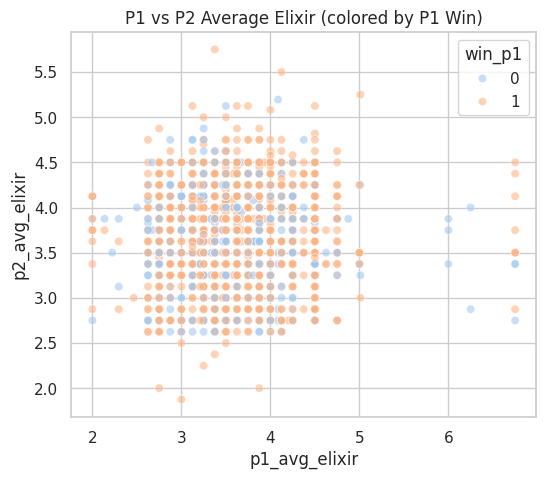

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", palette="pastel")
df["win_p1"] = (df["p1_crowns"] > df["p2_crowns"]).astype(int)


# ================================
# 1) Average Elixir Comparison
# ================================

df["p1_avg_elixir"] = df[[f"p1_{i}_elixir_cost" for i in range(1,9)]].mean(axis=1)
df["p2_avg_elixir"] = df[[f"p2_{i}_elixir_cost" for i in range(1,9)]].mean(axis=1)

plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x="p1_avg_elixir", y="p2_avg_elixir", hue="win_p1", alpha=0.6)
plt.title("P1 vs P2 Average Elixir (colored by P1 Win)")
plt.show()



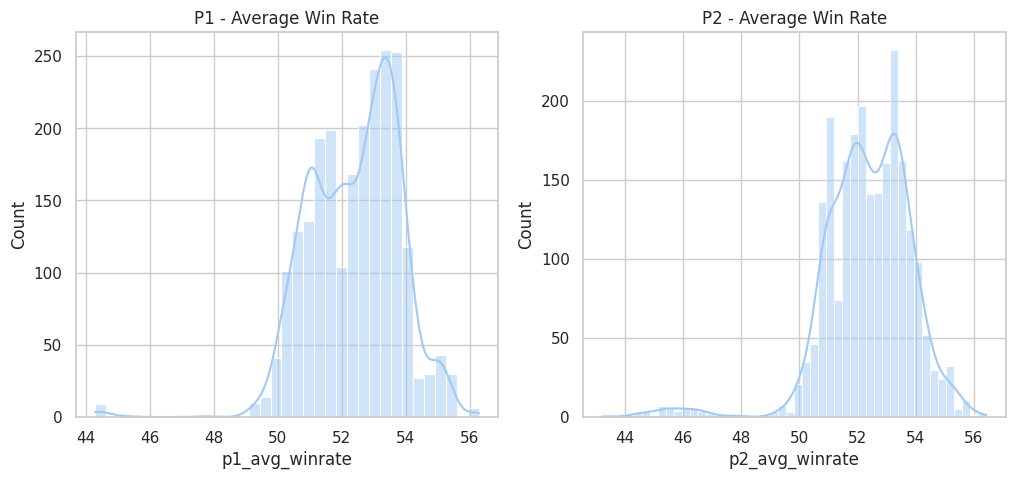

In [ ]:
# Win Rate Distribution per Deck

df["p1_avg_winrate"] = df[[f"p1_{i}_win_rate" for i in range(1,9)]].mean(axis=1)
df["p2_avg_winrate"] = df[[f"p2_{i}_win_rate" for i in range(1,9)]].mean(axis=1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df["p1_avg_winrate"], kde=True)
plt.title("P1 - Average Win Rate")

plt.subplot(1,2,2)
sns.histplot(df["p2_avg_winrate"], kde=True)
plt.title("P2 - Average Win Rate")
plt.show()

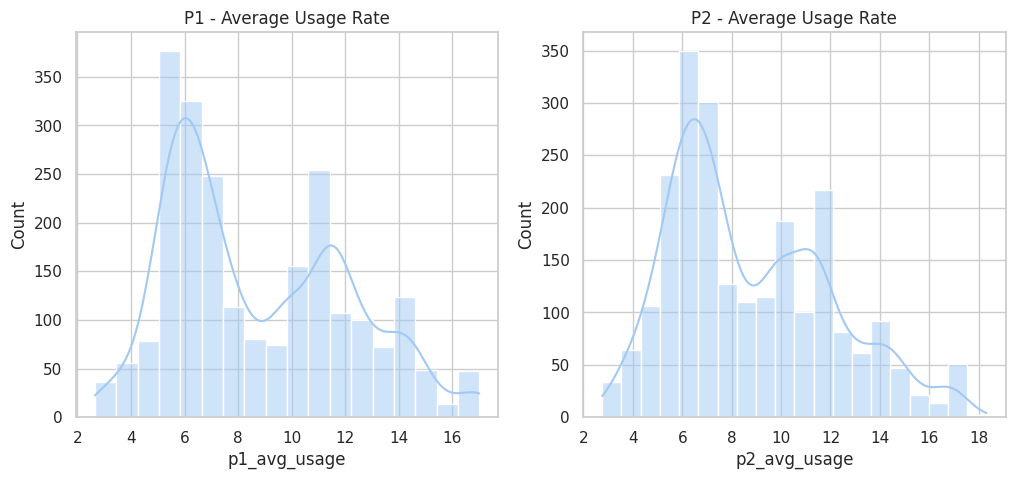

In [ ]:
# Usage Rate Distribution per Deck

df["p1_avg_usage"] = df[[f"p1_{i}_usage_rate" for i in range(1,9)]].mean(axis=1)
df["p2_avg_usage"] = df[[f"p2_{i}_usage_rate" for i in range(1,9)]].mean(axis=1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df["p1_avg_usage"], kde=True)
plt.title("P1 - Average Usage Rate")

plt.subplot(1,2,2)
sns.histplot(df["p2_avg_usage"], kde=True)
plt.title("P2 - Average Usage Rate")
plt.show()

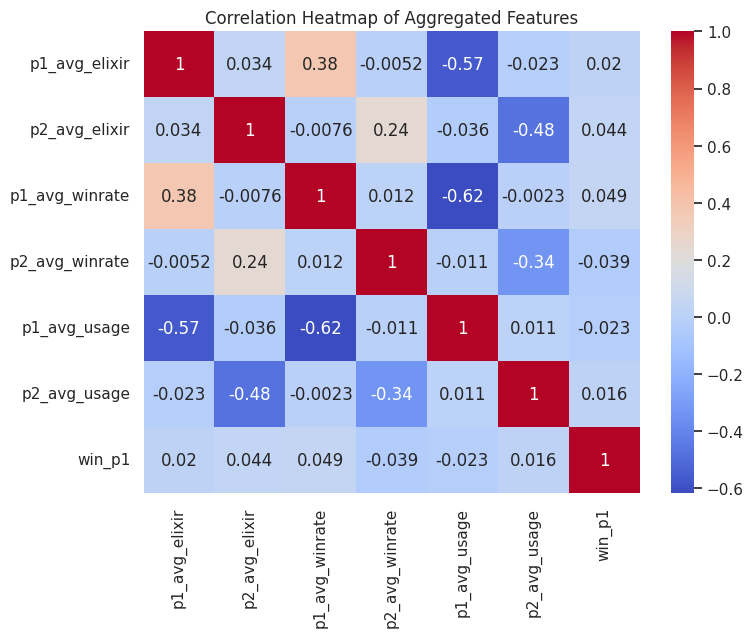

In [ ]:
# Correlation Heatmap (Aggregated Features)

agg_cols = ["p1_avg_elixir","p2_avg_elixir",
            "p1_avg_winrate","p2_avg_winrate",
            "p1_avg_usage","p2_avg_usage",
            "win_p1"]

plt.figure(figsize=(8,6))
sns.heatmap(df[agg_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Aggregated Features")
plt.show()

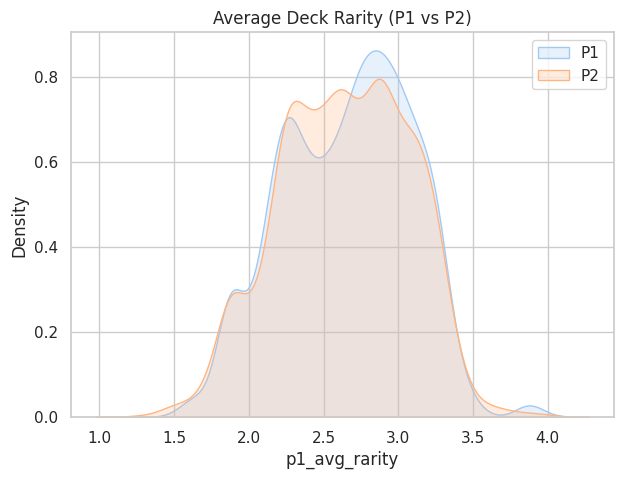

In [ ]:


#  Rarity Composition (P1 vs P2)


# map rarity to numbers
rarity_map = {"common":1, "rare":2, "epic":3, "legendary":4}
for i in range(1,9):
    df[f"p1_{i}_rarity_num"] = df[f"p1_{i}_rarity"].map(rarity_map)
    df[f"p2_{i}_rarity_num"] = df[f"p2_{i}_rarity"].map(rarity_map)

df["p1_avg_rarity"] = df[[f"p1_{i}_rarity_num" for i in range(1,9)]].mean(axis=1)
df["p2_avg_rarity"] = df[[f"p2_{i}_rarity_num" for i in range(1,9)]].mean(axis=1)

plt.figure(figsize=(7,5))
sns.kdeplot(df["p1_avg_rarity"], label="P1", shade=True)
sns.kdeplot(df["p2_avg_rarity"], label="P2", shade=True)
plt.title("Average Deck Rarity (P1 vs P2)")
plt.legend()
plt.show()




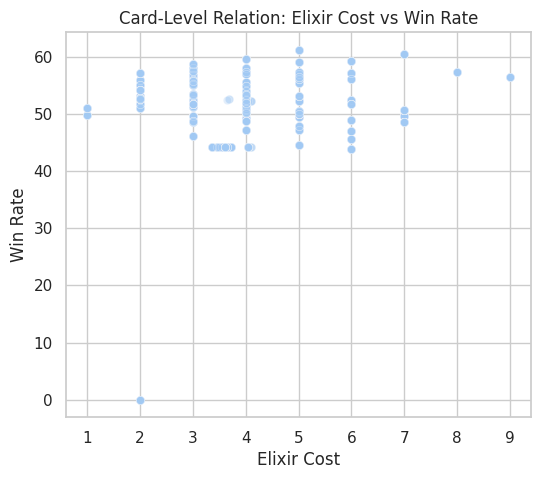

In [ ]:
# Elixir Cost vs Win Rate (Card Level)

all_cards_elixir = []
all_cards_win = []

for i in range(1,9):
    all_cards_elixir.extend(df[f"p1_{i}_elixir_cost"])
    all_cards_elixir.extend(df[f"p2_{i}_elixir_cost"])

    all_cards_win.extend(df[f"p1_{i}_win_rate"])
    all_cards_win.extend(df[f"p2_{i}_win_rate"])

plt.figure(figsize=(6,5))
sns.scatterplot(x=all_cards_elixir, y=all_cards_win, alpha=0.3)
plt.title("Card-Level Relation: Elixir Cost vs Win Rate")
plt.xlabel("Elixir Cost")
plt.ylabel("Win Rate")
plt.show()

## 4. Feature Engineering

In [ ]:
df["p1_avg_elixir"] = df[[f"p1_{i}_elixir_cost" for i in range(1,9)]].mean(axis=1)
df["p2_avg_elixir"] = df[[f"p2_{i}_elixir_cost" for i in range(1,9)]].mean(axis=1)
df["p1_avg_winrate"] = df[[f"p1_{i}_win_rate" for i in range(1,9)]].mean(axis=1)
df["p2_avg_winrate"] = df[[f"p2_{i}_win_rate" for i in range(1,9)]].mean(axis=1)
df["p1_avg_usage"] = df[[f"p1_{i}_usage_rate" for i in range(1,9)]].mean(axis=1)
df["p2_avg_usage"] = df[[f"p2_{i}_usage_rate" for i in range(1,9)]].mean(axis=1)

rarity_map = {"common":1,"rare":2,"epic":3,"legendary":4}

for i in range(1,9):
    df[f"p1_{i}_rarity_num"] = df[f"p1_{i}_rarity"].map(rarity_map)
    df[f"p2_{i}_rarity_num"] = df[f"p2_{i}_rarity"].map(rarity_map)

df["p1_avg_rarity"] = df[[f"p1_{i}_rarity_num" for i in range(1,9)]].mean(axis=1)
df["p2_avg_rarity"] = df[[f"p2_{i}_rarity_num" for i in range(1,9)]].mean(axis=1)
def overlap(d1, d2):
    return len(set(d1) & set(d2))

df["deck_overlap"] = [
    overlap(df.loc[i, [f"p1_{j}" for j in range(1,9)]],
            df.loc[i, [f"p2_{j}" for j in range(1,9)]])
    for i in range(len(df))
]

#DeckStrength(D) = average( P(D beats each deck in dataset) )



In [ ]:
# final feature set
A_features = [
    "p1_avg_elixir","p2_avg_elixir",
    "p1_avg_winrate","p2_avg_winrate",
    "p1_avg_usage","p2_avg_usage",
    "p1_avg_rarity","p2_avg_rarity",
    "deck_overlap"
]

X = df[A_features]
y = df["win_p1"]
X

,p1_avg_elixir,p2_avg_elixir,p1_avg_winrate,p2_avg_winrate,p1_avg_usage,p2_avg_usage,p1_avg_rarity,p2_avg_rarity,deck_overlap
0,2.750,3.375,51.74125,53.48000,11.35,7.01,2.625,2.875,0
1,2.750,3.250,51.74125,52.20375,11.35,11.85,2.625,2.875,5
2,3.125,4.500,52.21125,53.75375,9.83,5.36,2.375,3.000,0
3,3.125,4.250,52.21125,51.15000,9.83,5.92,2.375,2.625,0
4,3.125,3.750,52.21125,55.28000,9.83,4.54,2.375,2.750,1
...,...,...,...,...,...,...,...,...,...
2306,3.750,3.750,54.22000,51.59000,6.55,8.93,3.000,2.000,0
2307,3.750,3.625,54.22000,53.13125,6.55,9.29,3.000,3.125,5
2308,3.750,4.125,54.22000,54.34375,6.55,6.92,3.000,2.750,1
2309,3.750,3.500,54.22000,53.89500,6.55,12.01,3.000,2.750,0


## 5.Baseline Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# --- split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(max_depth=6),
    "KNN": KNeighborsClassifier(n_neighbors=9)
}

# --- evaluation ---
for name, model in models.items():
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, proba)

    print(f"\n{name}")
    print("Accuracy:", acc)
    print("ROC–AUC :", auc)




Logistic Regression
Accuracy: 0.7192224622030238
ROC–AUC : 0.5680963654087174

Decision Tree
Accuracy: 0.7105831533477321
ROC–AUC : 0.5481362855683981

KNN
Accuracy: 0.712742980561555
ROC–AUC : 0.5098988070370887


## 6. SearchGrid

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# ---------------- Logistic Regression ----------------
log_params = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["lbfgs", "liblinear"]
}

log_grid = GridSearchCV(
    LogisticRegression(max_iter=2000),
    log_params,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

log_grid.fit(X_train, y_train)

# ---------------- Decision Tree ----------------
tree_params = {
    "max_depth": [3, 5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

tree_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    tree_params,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

tree_grid.fit(X_train, y_train)

# ---------------- KNN ----------------
knn_params = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"]
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

knn_grid.fit(X_train, y_train)

# ---------------- Results ----------------
print("Best Logistic Regression Params:", log_grid.best_params_)
print("Best Logistic Regression AUC :", log_grid.best_score_)

print("\nBest KNN Params:", knn_grid.best_params_)
print("Best KNN AUC :", knn_grid.best_score_)

print("\nBest Decision Tree Params:", tree_grid.best_params_)
print("Best Decision Tree AUC :", tree_grid.best_score_)


Best Logistic Regression Params: {'C': 100, 'solver': 'liblinear'}
Best Logistic Regression AUC : 0.5571888651464366

Best KNN Params: {'n_neighbors': 11, 'weights': 'uniform'}
Best KNN AUC : 0.5141490755059888

Best Decision Tree Params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Decision Tree AUC : 0.5402815655188296


## 7 – Advanced Models

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.7 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# --- RANDOM FOREST ---
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:,1]

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Random Forest ROC–AUC :", roc_auc_score(y_test, rf_proba))


# --- XGBOOST ---
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_proba = xgb.predict_proba(X_test)[:,1]

print("\nXGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("XGBoost ROC–AUC :", roc_auc_score(y_test, xgb_proba))


# --- CATBOOST ---
cat = CatBoostClassifier(
    iterations=400,
    learning_rate=0.05,
    depth=6,
    verbose=0,
    random_state=42
)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_test)
cat_proba = cat.predict_proba(X_test)[:,1]

print("\nCatBoost Accuracy:", accuracy_score(y_test, cat_pred))
print("CatBoost ROC–AUC :", roc_auc_score(y_test, cat_proba))


Random Forest Accuracy: 0.7213822894168467
Random Forest ROC–AUC : 0.5657638211948196

XGBoost Accuracy: 0.7192224622030238
XGBoost ROC–AUC : 0.592651905491343

CatBoost Accuracy: 0.7278617710583153
CatBoost ROC–AUC : 0.6010537065404076


---

## 8. (brouillon) ici le but est d'entrer deux joueurs et de prédire le gagnant

In [ ]:
import pandas as pd
import numpy as np

#LOAD CARD DATASET (the ONLY required file)
cards = pd.read_csv("clash_royale_cards.csv")

cards = cards.rename(columns={
    "Card": "card_name",
    "elixirCost": "elixir_cost",
    "Win Rate": "win_rate",
    "Usage": "usage_rate"
})

def normalize(name):
    return str(name).lower().replace(" ", "").replace("-", "").replace(".", "")

cards["card_norm"] = cards["card_name"].apply(normalize)

clean_merged = cards.copy()   #IMPORTANT FIX



# 2)FIXED BUILD_MATCHUP_ROW + DECK_STRENGTH


def build_matchup_row(deck_p1, deck_p2):
    """
    Build the full feature row for predicting P1 vs P2.
    Works with your Phase 2 + Phase 3 strategic features.
    """

    f1 = compute_deck_features(deck_p1)
    f2 = compute_deck_features(deck_p2)

    f1 = {f"p1_{k}": v for k,v in f1.items()}
    f2 = {f"p2_{k}": v for k,v in f2.items()}

    merged = {**f1, **f2}

    merged["spell_diff"] = f1["p1_spells"] - f2["p2_spells"]
    merged["air_diff"] = f1["p1_air_units"] - f2["p2_air_units"]
    merged["anti_air_diff"] = f1["p1_anti_air"] - f2["p2_anti_air"]
    merged["tank_diff"] = f1["p1_tanks"] - f2["p2_tanks"]
    merged["splash_diff"] = f1["p1_splash"] - f2["p2_splash"]
    merged["cycle_diff"] = f1["p1_cycle_cards"] - f2["p2_cycle_cards"]
    merged["wincon_diff"] = f1["p1_wincons"] - f2["p2_wincons"]
    merged["synergy_diff"] = f1["p1_synergy_score"] - f2["p2_synergy_score"]
    merged["counter_diff"] = f1["p1_counter_score"] - f2["p2_counter_score"]

    row = pd.DataFrame([merged])[X.columns]  # X = your training features

    return row


def deck_strength(deck, model, df):
    """
    Computes average win probability of 'deck' vs all opponent decks in df.
    """
    opponents = df[[f"p1_{i}" for i in range(1,9)]].values.tolist()
    probs = []

    for opp in opponents:
        row = build_matchup_row(deck, opp)
        p = model.predict_proba(row)[0][1]
        probs.append(p)

    return float(np.mean(probs))


print("build_matchup_row & deck_strength loaded ✔")



# 3) MATCHUP PREDICTOR
def predict_matchup(deck_p1, deck_p2, model):
    row = build_matchup_row(deck_p1, deck_p2)
    return float(model.predict_proba(row)[0][1])


print("🔥 Matchup predictor system ready.")



# 4) EXAMPLES

hog_cycle = [
    "Hog Rider","Ice Spirit","Skeletons","Cannon",
    "Musketeer","Fireball","The Log","Ice Golem"
]

lava_loon = [
    "Lava Hound","Balloon","Mega Minion","Minions",
    "Tombstone","Arrows","Fireball","Inferno Dragon"
]

best_model = cat   # CHOOSE THE BEST MODEL FROM PHASE 3

print("Hog vs Lava matchup:", predict_matchup(hog_cycle, lava_loon, best_model))
print("Hog Cycle Strength:", deck_strength(hog_cycle, best_model, df))


build_matchup_row & deck_strength loaded ✔
🔥 Matchup predictor system ready.


NameError: name 'compute_deck_features' is not defined

## 9. (brouillon) ici le but est d'entrer un deck et de mesurer la force globale indépendamment d'un deck

In [ ]:
# ============================================================
# STEP 8 — DECK STRENGTH PREDICTOR (GLOBAL POWER LEVEL)
# Computes how strong a deck is on average vs all decks in the dataset
# ============================================================

def deck_strength(deck, clean_merged, model, df):
    """
    deck         -> list of 8 card names (string)
    clean_merged -> card stats dataset
    model        -> trained best_model from Phase 3
    df           -> full dataset containing p1_1...p1_8
    """

    # list of all opponent decks (p1 decks of the dataset)
    opponents = df[[f"p1_{i}" for i in range(1,9)]].values.tolist()

    probs = []
    for opp in opponents:
        row = build_matchup_row(deck, opp, clean_merged)
        p = model.predict_proba(row)[0][1]   # proba that deck beats opp
        probs.append(p)

    return float(np.mean(probs))  # mean win probability


print("Deck Strength Predictor Ready ✔")


# Hog Cycle
hog_cycle = [
    "Hog Rider","The Log","Fireball","Cannon",
    "Ice Spirit","Skeletons","Musketeer","Ice Golem"
]

# LavaLoon
lava_loon = [
    "Lava Hound","Balloon","Mega Minion","Minions",
    "Fireball","Arrows","Tombstone","Inferno Dragon"
]

# X-Bow 3.0
xbow = [
    "X-Bow","Tesla","Fireball","The Log",
    "Skeletons","Ice Spirit","Archers","Knight"
]

# Royal Giant
royal_giant = [
    "Royal Giant","Fisherman","Mother Witch","Fireball",
    "Hunter","Electro Spirit","Mega Minion","Goblin Cage"
]

# Golem Beatdown
golem = [
    "Golem","Baby Dragon","Tornado","Night Witch",
    "Lightning","Mega Minion","Bomber","Barbarian Barrel"
]




Deck Strength Predictor Ready ✔


In [ ]:
# Hog Cycle
hog_cycle = [
    "Hog Rider","The Log","Fireball","Cannon",
    "Ice Spirit","Skeletons","Musketeer","Ice Golem"
]

# LavaLoon
lava_loon = [
    "Lava Hound","Balloon","Mega Minion","Minions",
    "Fireball","Arrows","Tombstone","Inferno Dragon"
]

# X-Bow 3.0
xbow = [
    "X-Bow","Tesla","Fireball","The Log",
    "Skeletons","Ice Spirit","Archers","Knight"
]

# Royal Giant
royal_giant = [
    "Royal Giant","Fisherman","Mother Witch","Fireball",
    "Hunter","Electro Spirit","Mega Minion","Goblin Cage"
]

# Golem Beatdown
golem = [
    "Golem","Baby Dragon","Tornado","Night Witch",
    "Lightning","Mega Minion","Bomber","Barbarian Barrel"
]


print("Hog Cycle Strength:", deck_strength(hog_cycle, clean_merged, best_model, df))
print("LavaLoon Strength:", deck_strength(lava_loon, clean_merged, best_model, df))
print("X-Bow Strength:", deck_strength(xbow, clean_merged, best_model, df))
print("Royal Giant Strength:", deck_strength(royal_giant, clean_merged, best_model, df))
print("Golem Beatdown Strength:", deck_strength(golem, clean_merged, best_model, df))


TypeError: build_matchup_row() takes 2 positional arguments but 3 were given

----

7. Dimension reduction

8. Ensemble models + advanced models

9. Overall coherence + comments